In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

print('All Packages Imported Successfully')

All Packages Imported Successfully


In [2]:
# Load the dataset to examine its structure
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its contents
data.head()

,Date,State,Humidity,Seasonality,Buffer Stock,Rainfall,Category,Price
0,2023-01-01,Andhra Pradesh,26.88,Rabi,137.09,19.95,Onion,28.62
1,2023-01-01,Andhra Pradesh,26.88,Rabi,137.09,19.95,Potato,21.05
2,2023-01-01,Andhra Pradesh,26.88,Rabi,137.09,19.95,Gram,64.46
3,2023-01-01,Andhra Pradesh,26.88,Rabi,137.09,19.95,Tur,72.19
4,2023-01-01,Andhra Pradesh,26.88,Rabi,137.09,19.95,Urad,65.78


In [3]:
data['Date'] = pd.to_datetime(data['Date'])
label_encoder_state = LabelEncoder()
label_encoder_category = LabelEncoder()
label_encoder_seasonality = LabelEncoder()

data['State'] = label_encoder_state.fit_transform(data['State'])
data['Category'] = label_encoder_category.fit_transform(data['Category'])
data['Seasonality'] = label_encoder_seasonality.fit_transform(data['Seasonality'])

In [4]:
# Features to scale
scaler = MinMaxScaler()
scaled_columns = ['Humidity', 'Buffer Stock', 'Rainfall', 'Price']
data[scaled_columns] = scaler.fit_transform(data[scaled_columns])

In [5]:
# Select features and target (Price) for LSTM
features = data[['State', 'Humidity', 'Seasonality', 'Buffer Stock', 'Rainfall', 'Category']].values
target = data['Price'].values


In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

In [7]:
# Convert to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
X_test_tensor = torch.Tensor(X_test)
y_train_tensor = torch.Tensor(y_train)
y_test_tensor = torch.Tensor(y_test)

In [8]:
# Reshape the input to [batch, sequence, feature] for LSTM
X_train_tensor = X_train_tensor.view(X_train_tensor.shape[0], 1, X_train_tensor.shape[1])
X_test_tensor = X_test_tensor.view(X_test_tensor.shape[0], 1, X_test_tensor.shape[1])

In [9]:
# Create PyTorch Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])  # get the last time step output
        return out

In [11]:
input_size = X_train_tensor.shape[2]

In [12]:
model = LSTMModel(input_size, hidden_size=100, output_size=1, num_layers=2)  # Increase num_layers
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for features_batch, target_batch in train_loader:
        # Forward pass
        outputs = model(features_batch)
        loss = criterion(outputs.squeeze(), target_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [5/20], Loss: 0.0027
Epoch [10/20], Loss: 0.0050
Epoch [15/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0046


In [14]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_predictions = []
    actual_values = []
    for features_batch, target_batch in test_loader:
        outputs = model(features_batch)
        test_predictions.append(outputs.squeeze().numpy())
        actual_values.append(target_batch.numpy())

In [15]:
# Flatten predictions and actual values
test_predictions = np.concatenate(test_predictions)
actual_values = np.concatenate(actual_values)

In [16]:
# Prepare data for inverse scaling
# Create a placeholder for the scaled values with the same number of features
scaled_values = np.zeros((len(test_predictions), len(scaled_columns)))

# Insert the predicted and actual price values into the appropriate index
scaled_values[:, -1] = test_predictions  # 'Price' was the last scaled column
actual_values_scaled = np.zeros((len(actual_values), len(scaled_columns)))
actual_values_scaled[:, -1] = actual_values  # Same for actual prices

# Now inverse transform using only the 'Price' column
test_predictions_real = scaler.inverse_transform(scaled_values)[:, -1]
actual_values_real = scaler.inverse_transform(actual_values_scaled)[:, -1]

# Now you can compare the real prices


In [17]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - test_predictions) / actual_values)) * 100

# Accuracy is the complement of the error
accuracy = 100 - mape
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 89.42%


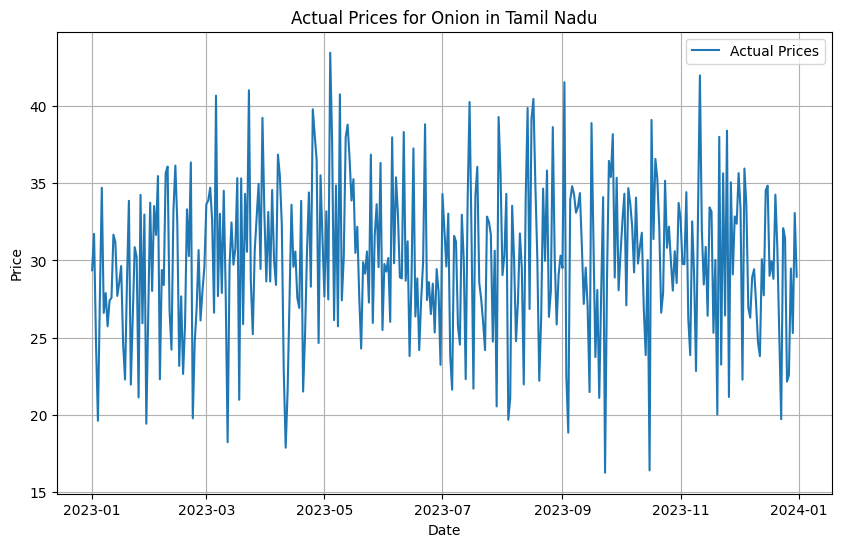

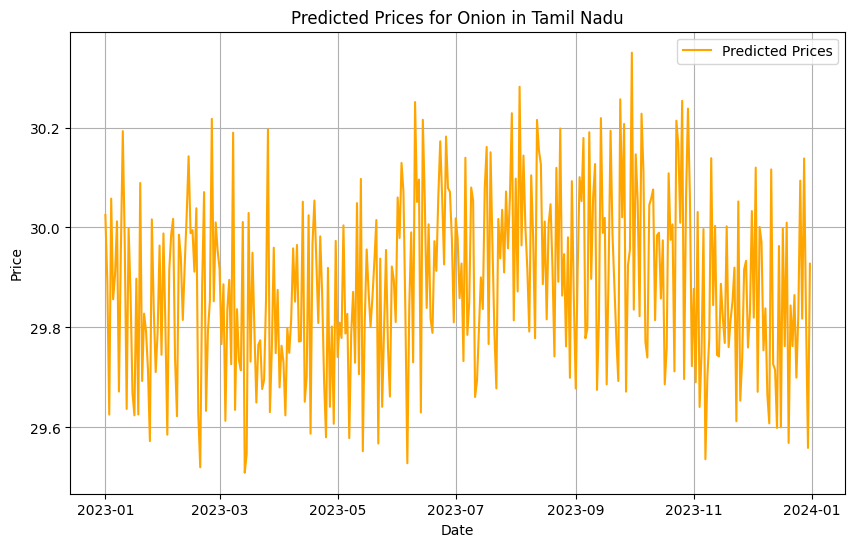

In [20]:
import matplotlib.pyplot as plt

# Filter the dataset for Tamil Nadu and a specific crop (e.g., Onion)
state = "Tamil Nadu"
crop = "Onion"

# Convert state and crop names to encoded values
state_encoded = label_encoder_state.transform([state])[0]
category_encoded = label_encoder_category.transform([crop])[0]

# Filter the data for the selected state and crop
tamilnadu_crop_data = data[(data['State'] == state_encoded) & (data['Category'] == category_encoded)]

# Extract actual prices and features from filtered data
actual_prices_tn_crop = tamilnadu_crop_data['Price'].values
features_tn_crop = tamilnadu_crop_data[['State', 'Humidity', 'Seasonality', 'Buffer Stock', 'Rainfall', 'Category']].values

# Convert features to PyTorch tensor
features_tn_crop_tensor = torch.Tensor(features_tn_crop).view(features_tn_crop.shape[0], 1, features_tn_crop.shape[1])

# Make predictions for the filtered data
model.eval()
with torch.no_grad():
    predicted_prices_tn_crop = model(features_tn_crop_tensor).squeeze().numpy()

# Inverse transform both actual and predicted prices
scaled_actual = np.zeros((len(actual_prices_tn_crop), len(scaled_columns)))
scaled_predicted = np.zeros((len(predicted_prices_tn_crop), len(scaled_columns)))

scaled_actual[:, -1] = actual_prices_tn_crop
scaled_predicted[:, -1] = predicted_prices_tn_crop

actual_prices_real = scaler.inverse_transform(scaled_actual)[:, -1]
predicted_prices_real = scaler.inverse_transform(scaled_predicted)[:, -1]

# Plot actual prices
plt.figure(figsize=(10,6))
plt.plot(tamilnadu_crop_data['Date'], actual_prices_real, label='Actual Prices')
plt.title(f'Actual Prices for {crop} in {state}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot predicted prices
plt.figure(figsize=(10,6))
plt.plot(tamilnadu_crop_data['Date'], predicted_prices_real, label='Predicted Prices', color='orange')
plt.title(f'Predicted Prices for {crop} in {state}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
import torch

# Save the model to a .pkl file
model_file_path = 'lstm_price_prediction_model.pkl'
torch.save(model.state_dict(), model_file_path)

print(f"Model saved to {model_file_path}")

Model saved to lstm_price_prediction_model.pkl


In [22]:
# Load the saved model
model = LSTMModel(input_size, hidden_size=100, output_size=1, num_layers=2)
model.load_state_dict(torch.load('lstm_price_prediction_model.pkl'))
model.eval()  # Set the model to evaluation mode

C:\Users\jagaj\AppData\Local\Temp\ipykernel_13616\2299971214.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lstm_price_prediction_mode

LSTMModel(
  (lstm): LSTM(6, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [23]:
# Function to make predictions for a given category
def predict_for_category(state, humidity, seasonality, buffer_stock, rainfall, category_name):
    # Convert categorical data to numerical values using the previously fitted LabelEncoders
    state_encoded = label_encoder_state.transform([state])[0]
    seasonality_encoded = label_encoder_seasonality.transform([seasonality])[0]
    category_encoded = label_encoder_category.transform([category_name])[0]
    
    # Prepare the input features as a tensor
    input_features = torch.Tensor([[state_encoded, humidity, seasonality_encoded, buffer_stock, rainfall, category_encoded]])
    
    # Reshape to match LSTM input format [batch_size, sequence_length, input_size]
    input_features = input_features.view(1, 1, -1)  # 1 sample, 1 time step, feature_size
    
    # Make prediction
    with torch.no_grad():
        predicted_price = model(input_features).item()  # Get the prediction
    
    # Inverse transform the predicted price to get the real price
    scaled_values = np.zeros((1, len(scaled_columns)))  # Initialize an array for inverse transform
    scaled_values[:, -1] = predicted_price  # Place the predicted price in the 'Price' column
    real_price = scaler.inverse_transform(scaled_values)[:, -1][0]  # Inverse scale the price
    
    return real_price

In [24]:
# Example usage:
state = "Andhra Pradesh"
humidity = 26.88
seasonality = "Rabi"
buffer_stock = 137.09
rainfall = 19.95
category_name = "Urad"

In [25]:
predicted_price = predict_for_category(state, humidity, seasonality, buffer_stock, rainfall, category_name)
print(f"The predicted price for {category_name} in {state} is: {predicted_price:.2f}")

The predicted price for Urad in Andhra Pradesh is: 60.19
